In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import joblib

In [4]:
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": -23.55,
    "longitude": -46.63,
    "start_date": "2020-01-01",
    "end_date": "2023-12-31",
    "daily": ["shortwave_radiation_sum", "temperature_2m_max", "cloudcover_mean", "precipitation_sum"],
    "timezone": "America/Sao_Paulo"
}
r = requests.get(url, params=params).json()

df = pd.DataFrame({
    "date": r["daily"]["time"],
    "radiation": r["daily"]["shortwave_radiation_sum"],
    "temperature": r["daily"]["temperature_2m_max"],
    "cloudcover": r["daily"]["cloudcover_mean"],
    "precipitation": r["daily"]["precipitation_sum"]
})

df["date"] = pd.to_datetime(df["date"])
df["generation_kWh"] = df["radiation"] * 0.2
df.to_csv("../data/solar.csv", index=False)
print(df.head())

        date  radiation  temperature  cloudcover  precipitation  \
0 2020-01-01      27.94         31.1          76            5.4   
1 2020-01-02      14.01         28.0          95           36.5   
2 2020-01-03      16.62         23.7          83            8.8   
3 2020-01-04      16.58         24.7          77            8.5   
4 2020-01-05      15.32         24.0          86            8.7   

   generation_kWh  
0           5.588  
1           2.802  
2           3.324  
3           3.316  
4           3.064  


In [6]:
df["dayofyear"] = df["date"].dt.dayofyear
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year
df["lag_1"] = df["generation_kWh"].shift(1)

df = df.dropna()

X = df[["dayofyear", "month", "lag_1", "temperature", "cloudcover", "precipitation"]]
y = df["generation_kWh"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

MAE: 0.33, RMSE: 0.45, R²: 0.864


c:\Users\ERICA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


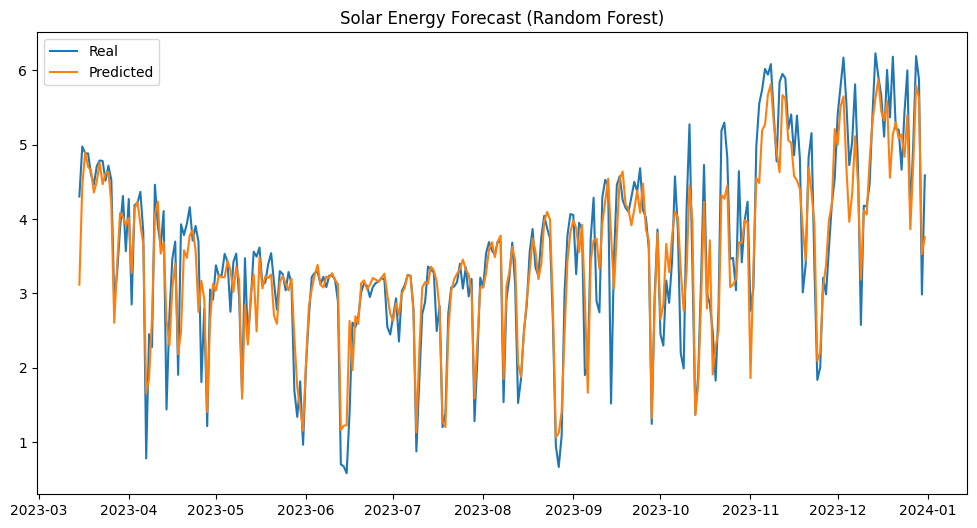

In [7]:

model = RandomForestRegressor(n_estimators=300, random_state=42)
model.fit(X_train, y_train)

pred = model.predict(X_test)
mae = mean_absolute_error(y_test, pred)
rmse = mean_squared_error(y_test, pred, squared=False)
r2 = r2_score(y_test, pred)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.3f}")

plt.figure(figsize=(12,6))
plt.plot(df["date"].iloc[-len(y_test):], y_test, label="Real")
plt.plot(df["date"].iloc[-len(y_test):], pred, label="Predicted")
plt.legend()
plt.title("Solar Energy Forecast (Random Forest)")
plt.show()

In [8]:
joblib.dump(model, "../model.pkl")
joblib.dump(scaler, "../scaler.pkl")

['../scaler.pkl']